# 作业3：深度学习框架实践

本次作业将练习深度学习框架的使用，大部分内容用 PyTorch 实现。第1题利用卷积层和全连接层实现手写数字的识别，第2题利用 RNN 来实现英文名的自动生成，第3题是算法题，利用卷积运算实现任意大整数的乘法。

### 第1题

1. 目标：通过对 MNIST 数据进行训练，构建一个简单的图像分类模型，对图片中的数字进行识别。你将利用该模型对自己真实手写出的数字进行预测，观察模型效果。

2. 主要步骤：获取数据，创建模型结构，定义损失函数，编写训练循环，实施预测。

3. 获取数据。我们使用知名的 MNIST 数据集，它可以从 PyTorch 中利用工具函数下载得到。原始的 MNIST 数据训练集大小为60000，我们随机抽取其中的10000个观测进行简单的训练。以下函数会在当前目录建立一个名为 data 的文件夹，其中会包含下载得到的数据集。

**注意：请在任何程序的最开始加上随机数种子的设置。请保持这一习惯。**

In [9]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

np.random.seed(123)
torch.manual_seed(123)

mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
loader = DataLoader(mnist, batch_size=10000, shuffle=True)

我们一次性取出随机抽取到的10000个观测，其中 x 是图片数据，y 是图片对应的数字。

In [10]:
x, y = next(iter(loader))

一个习惯性动作是查看数据的大小和维度。

In [11]:
print(x.shape)
print(y.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


我们可以利用下面的函数展示图片的内容。如选择第一张图片，先将其转换成 Numpy 数组，再绘制图形：

(28, 28)


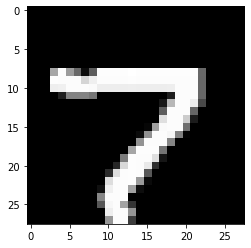

In [12]:
import matplotlib.pyplot as plt

img = x[0].squeeze().cpu().numpy()
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

接下来请你选择5个你喜欢的数字（10000以下），然后取出对应位置的图片，并画出它们的内容。

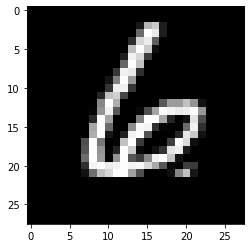

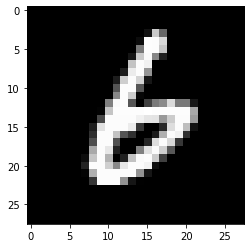

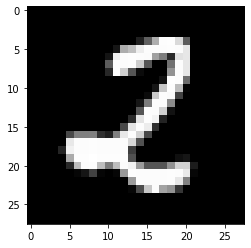

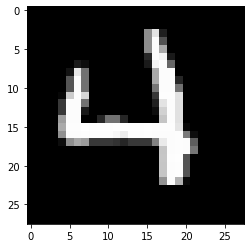

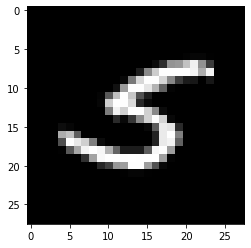

In [13]:
import matplotlib.pyplot as plt
like_num=[1996,626,50,1993,1015]
for j in like_num:
    img = x[j].squeeze().cpu().numpy()
    plt.imshow(img, cmap="gray")
    plt.show()

4. 搭建模型。我们搭建一个类似于 LeNet-5 的网络，结构如下：

![](https://pic1.zhimg.com/80/v2-82eabb4c17e90d467197d013f7629f3c_720w.jpg)

我们需要创建2个卷积层、2个汇聚层（池化层）和2个全连接层，**暂时忽略所有的激活函数**。所有隐藏层的函数细节都可以在[官方文档](https://pytorch.org/docs/stable/nn.html)中按分类找到。每一个隐藏层本质上都是将一个数组变换成另一个数组的函数，因此为了确认编写的模型是正确的，可以先用一个小数据进行测试，观察输入和输出的维度。例如，我们先取出前10个观测，此时输入的维度是 `[10, 1, 28, 28]`：

In [14]:
smallx = x[0:10]
smally = y[0:10]
print(smallx.shape)
print(smally.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


接下来创建第1个卷积层，并测试输出的维度。注意到我们可以直接将隐藏层当成一个函数来调用。

In [15]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
res = conv1(smallx)
print(res.shape)

torch.Size([10, 20, 24, 24])


可以看到，输出的维度为 `[20, 24, 24]`（不包括第1位的数据批次维度），与之前图中的结果吻合。

接下来，请按照图中提示编写层对象 `pool1`、`conv2`、`pool2`、`fc1` 和 `fc2`，并顺次测试输入与输出的维度，使其与上图匹配。注意，在将一个大小为 `[10, 50, 4, 4]` 的数组（假设叫 `somearray`）传递给 `fc1` 之前，需要先将其变形为只有两个维度的数组，做法是 `somearray.view(-1, 50*4*4)`，其中 -1 表示该位置的大小不变。

```py
pool1 = ...
res = pool1(res)
print(res.shape)

conv2 = ...
res = conv2(res)
print(res.shape)

pool2 = ...
res = pool2(res)
print(res.shape)

fc1 = ...
res = fc1(res.view(-1, 50 * 4 * 4))
print(res.shape)

fc2 = ...
res = fc2(res)
print(res.shape)
```

In [16]:
pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
res = pool1(res)
print(res.shape)
conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
res = conv2(res)
print(res.shape)
pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
res = pool2(res)
print(res.shape)

torch.Size([10, 20, 12, 12])
torch.Size([10, 50, 8, 8])
torch.Size([10, 50, 4, 4])


In [ ]:
fc1 = torch.nn.Linear(in_features=800, out_features=500)
res = fc1(res.view(-1, 50 * 4 * 4))
print(res.shape)

In [1]:
fc2 = torch.nn.Linear(in_features=500, out_features=10)
res = fc2(res)
print(res.shape)            #代码没问题，但是电脑内存不足，服务器会提示挂掉

NameError: name 'torch' is not defined

5. 创建模型类。在确保隐藏层维度都正确后，将所有的隐藏层封装到一个模型类中，其中模型结构在 `__init__()` 中定义，具体的计算过程在 `forward()` 中实现。此时需要加入激活函数。在本模型中，**请在 `conv1`、`conv2` 和 `fc1` 后加入 ReLU 激活函数，并在 `fc2` 后加入 Softmax 激活函数**。

```py
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ...
        self.pool1 = ...
        self.conv2 = ...
        self.pool2 = ...
        self.fc1 = ...
        self.fc2 = ...

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        ...
        return x
```

In [ ]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=800, out_features=500)
        self.fc2 = torch.nn.Linear(in_features=500, out_features=10)

    def forward(self, x):
        
        x = self.conv1(x)
        x = torch.relu(x)     #20*24*24
        x = self.pool1(x)     #20*12*12
        x = self.conv2(x)     
        x = torch.relu(x)     #50*8*8
        x = self.pool2(x)     #50*4*4
        x=self.fc1(x.view(-1,50*4*4))
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.softmax(x,dim=1)
        return x

再次测试输入输出的维度是否正确。如果模型编写正确，输出的维度应该是 `[10, 10]`，且输出结果为0到1之间的概率值。

In [ ]:
np.random.seed(123)
torch.manual_seed(123)

model = MyModel()
pred = model(smallx)
print(pred.shape)
print(pred)

`pred` 的每一行加总为1，其中每一个元素代表对应类别的预测概率。

我们还可以直接打印模型对象，观察隐藏层的结构：

In [ ]:
print(model)

6. 损失函数。对于分类问题，损失函数通常选取为负对数似然函数。在 PyTorch 中，可以使用 `torch.nn.NLLLoss` 来完成计算。其用法是先定义一个损失函数对象，然后在预测值和真实标签上调用该函数对象。注意：损失函数对象的第一个参数是预测概率的**对数值**，第二个参数是真实的标签。[文档说明](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)。

In [ ]:
lossfn = torch.nn.NLLLoss()
lossfn(torch.log(pred), smally)

7. 利用课上介绍的循环模板和代码示例，对模型进行迭代训练。对于本数据，选取 mini-batch 大小为200，共遍历数据10遍，优化器选为 Adam，学习率为0.001。

In [ ]:
nepoch = 10
batch_size = 200

opt = torch.optim.Adam(model.parameters(), lr=0.001)

n = x.shape[0]
obs_id = np.arange(n)  # [0, 1, ..., n-1]
# Run the whole data set `nepoch` times
for i in range(nepoch):
    # Shuffle observation IDs
    np.random.shuffle(obs_id)

    # Update on mini-batches
    for j in range(0, n, batch_size):
        # Create mini-batch
        x_mini_batch = x[obs_id[j:(j + batch_size)]]
        y_mini_batch = y[obs_id[j:(j + batch_size)]]
        # Compute loss
        pred = model(x_mini_batch)
        lossfn = torch.nn.CrossEntropyLoss()
        loss = lossfn(pred, y_mini_batch)
        # Compute gradient and update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (j // batch_size) % 10 == 0:
            print(f"epoch {i}, batch {j // batch_size}, loss = {loss.item()}")

为了验证模型的效果，我们对前10个观测（即之前生成的 `smallx` 和 `smally`）进行预测。

In [ ]:
ypred = model(smallx)
print(np.round(ypred.detach().cpu().numpy(), 3))
print(smally)

如果模型搭建和训练都正常，那么每一行中概率最大的取值所在的位置应该正好对应真实的标签。

最后，我们用模型对一些真实的手写数字图片进行预测。请你利用绘图软件（如 Windows 自带的绘图，或 Photoshop 等）准备10张正方形黑色底色的图片，每张用鼠标绘制一个数字（请使用较粗的笔划），从0到9，然后以0.png，1.png等文件名存储下来，放到当前目录一个名为 digits 的文件夹中。以下是几个例子：
![](digits/sample0.png) ![](digits/sample5.png) ![](digits/sample8.png)

接下来利用 Pillow 软件包读取图片：

In [ ]:
from PIL import Image
im = Image.open("digits/sample0.png")
im

此时如果直接将其转为 Numpy 数组会得到三个通道：

In [29]:
im_arr = np.array(im)
print(im_arr.shape)

(261, 261, 3)


因此，我们先强制转换为灰度图片（单通道），再缩放至模型的图片大小 28 x 28：

In [30]:
im = im.convert("L")
im.thumbnail((28, 28))
im_arr = np.array(im)
print(im_arr.shape)
im

(28, 28)


为了传递给模型对象，还需要先将数值归一化到 [0,1] 区间，转换为 PyTorch 的 Tensor 类型，并增加一个批次和一个通道的维度：

In [31]:
test0 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
print(test0.shape)

torch.Size([1, 1, 28, 28])


最后对图片标签进行预测：

In [32]:
pred0 = model(test0)
print(np.round(pred0.detach().cpu().numpy(), 3))

[[0.639 0.    0.    0.    0.    0.    0.    0.    0.    0.361]]


预测结果是否符合真实情形？请对你自己绘制出的10张图片进行类似的预测操作，并评价其效果。

由于本人电脑在试用torch时，内存不足会挂掉，所以就不做预测操作了。
评价：基本效果较好，但是对输入图片的质量要求比较高，只有当数字充满整张图片时才会有较好的预测结果。

### 第2题

1. 目标：通过对英文名数据进行训练，构建一个 RNN 模型，实现英文名的自动生成。

2. 主要步骤：获取和整理数据，对字符串进行 one-hot 编码，创建模型结构，定义损失函数，编写训练循环，最后生成人名字符串。

3. 获取和整理数据。数据文件已存为 `data/names.txt`，先将其读取为字符串列表：

In [1]:
import io
lines = io.open("data/names.txt").read().strip().split('\n')
print(len(lines))
print(lines[0:5])

3668
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


可以看出，共读取了3668个名字。为了简单起见，我们将所有的大写字母转换为小写。

In [2]:
names = [s.lower() for s in lines]
print(names[0:5])

['abbas', 'abbey', 'abbott', 'abdi', 'abel']


接下来我们需要构建一个字符的字典。对于英文名来说很简单，即26个字母。我们可以通过下面的代码直接得到。

In [3]:
import string
dict = string.ascii_lowercase
dict

'abcdefghijklmnopqrstuvwxyz'

4. 下面准备好 one-hot 编码所需的函数。编写函数 `char2index(char)`，将一个字母转换为其所在字典的位置。例如 `char2index("a")` 要返回0，`char2index("z")` 要返回25，等等。提示：使用字符串的 `.find()` 函数。

In [5]:
def char2index(char):
    return dict.find(char)

print(char2index("z") == 25)

True


编写 `char2tensor(char)` 函数，将一个字母转换为 one-hot 向量，即该向量中第 i 个元素为1，其余为0，其中 i 表示该字母在字典中的位置。

**注意，该向量的长度应为27，因为我们要预留终止符，用 `[0.0, 0.0, ..., 1.0]` 表示**。

`char2tensor("a")` 应返回 `torch.tensor([1.0, 0.0, ...])`，`char2tensor("z")` 应返回 `torch.tensor([0.0, ..., 1.0, 0.0])`。

In [52]:
def char2tensor(char):
    tensor = torch.zeros(27)
    tensor[char2index(char)] = 1
    return tensor

print(char2tensor("a"))
print(char2tensor("z"))
print(char2tensor("z").shape[0] == 27)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.])
True


5. 构建模型。我们使用最简单的 RNN 结构，即隐藏单元是输入和上一期隐藏单元的线性变换加上 Tanh 激活函数，输出单元是隐藏单元的线性变换加上 Softmax 激活函数。输出的结果代表下一个字符的概率分布。

```py
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = ...
        self.h2o = ...

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output = torch.nn.functional.softmax(self.h2o(hidden), dim=1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
```

In [9]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(input_size+hidden_size , hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, 27)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output = torch.nn.functional.softmax(self.h2o(hidden), dim=1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)



我们做一个简单的测试。请在下面的代码中加入适当的语句，使得每次运行的结果不变。根据其输出结果，请问当前模型预测字符a的下一个字符是什么？为什么？

In [13]:
np.random.seed(123)
torch.random.manual_seed(123)
rnn = RNN(input_size=27, hidden_size=10)
input = char2tensor("a")
hidden = rnn.init_hidden()
output, hidden = rnn(input.view(1, 27), hidden)
print(output)

tensor([[0.0290, 0.0327, 0.0320, 0.0354, 0.0432, 0.0395, 0.0417, 0.0371, 0.0409,
         0.0275, 0.0328, 0.0359, 0.0373, 0.0391, 0.0339, 0.0366, 0.0430, 0.0364,
         0.0472, 0.0435, 0.0376, 0.0327, 0.0418, 0.0370, 0.0279, 0.0426, 0.0357]],
       grad_fn=<SoftmaxBackward>)


是S,因为S的概率最大。

6. 接下来我们定义好损失函数。与第1题中类似，预测值是一个概率分布，而真实的标签是0到26中的一个整数，代表真实的下一个字符在字典中的位置。假设当前处理的名字为"abel"，那么字符a的输出结果对应的标签是什么？请完成下面的代码。

In [14]:
# Change "target" to a proper value
target = 26

lossfn = torch.nn.NLLLoss()
loss = lossfn(torch.log(output), torch.tensor([target]))
print(loss)

tensor(3.3336, grad_fn=<NllLossBackward>)


7. 明确单个字符的损失函数的计算方法后，请在下面计算出"abel"这个观测整体的损失函数值。

In [19]:
name=['abel']
nchar = len(name)
loss = 0.0
hidden = rnn.init_hidden()
for j in range(nchar):
    input = char2tensor(name[j])
    output, hidden = rnn(input.view(1, n_input), hidden)
    if j == nchar - 1:
        target = 26
    else:
        target = char2index(name[j + 1])
    loss = loss + lossfn(torch.log(output), torch.tensor([target]))
loss = loss / nchar
print(loss)

tensor(3.6255, grad_fn=<DivBackward0>)


8. 将上述过程在数据上进行反复迭代，训练模型。

In [15]:
np.random.seed(123)
torch.random.manual_seed(123)

n = len(names)
n_hidden = 16
n_input = 27
nepoch = 10

rnn = RNN(n_input, n_hidden)
opt = torch.optim.Adam(rnn.parameters(), lr=0.0001)
train_ind = np.arange(n)
losses = []

lossfn = torch.nn.NLLLoss()

# Loop over epochs
for k in range(nepoch):
    # Shuffle the data
    np.random.shuffle(train_ind)
    # Loop over observations. Each observation is a name
    for i in range(n):
        name = names[train_ind[i]]
        nchar = len(name)
        # Loop over the characters in the name
        # Each input character has a target, which is the index of the next character in the dictionary
        # For the last character in the name, the target is the end-of-sequence symbol, which has index 26
        loss = 0.0
        hidden = rnn.init_hidden()
        for j in range(nchar):
            input = char2tensor(name[j])
            output, hidden = rnn(input.view(1, n_input), hidden)

            if j == nchar - 1:
                target = 26
            else:
                target = char2index(name[j + 1])

            loss = loss + lossfn(torch.log(output), torch.tensor([target]))
    
        loss = loss / nchar

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if i % 1000 == 0:
            print(f"epoch {k}, obs {i}, loss = {loss.item()}")

epoch 0, obs 0, loss = 3.3991856575012207
epoch 0, obs 1000, loss = 2.918344020843506
epoch 0, obs 2000, loss = 2.6398532390594482
epoch 0, obs 3000, loss = 3.1096529960632324
epoch 1, obs 0, loss = 2.776276111602783
epoch 1, obs 1000, loss = 2.5617995262145996
epoch 1, obs 2000, loss = 2.415987014770508
epoch 1, obs 3000, loss = 2.4527029991149902
epoch 2, obs 0, loss = 2.5975749492645264
epoch 2, obs 1000, loss = 2.585355520248413
epoch 2, obs 2000, loss = 2.5821337699890137
epoch 2, obs 3000, loss = 2.7673683166503906
epoch 3, obs 0, loss = 2.584155797958374
epoch 3, obs 1000, loss = 2.1915831565856934
epoch 3, obs 2000, loss = 2.4389891624450684
epoch 3, obs 3000, loss = 2.0150928497314453
epoch 4, obs 0, loss = 2.4576306343078613
epoch 4, obs 1000, loss = 2.9122250080108643
epoch 4, obs 2000, loss = 2.5470449924468994
epoch 4, obs 3000, loss = 2.1251466274261475
epoch 5, obs 0, loss = 2.283302068710327
epoch 5, obs 1000, loss = 2.564319133758545
epoch 5, obs 2000, loss = 2.1136810

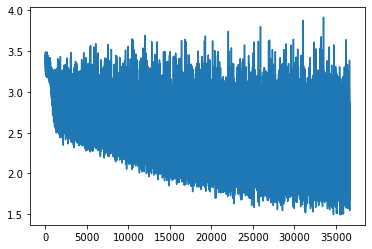

In [20]:
import matplotlib.pyplot as plt
plt.plot(losses)

9. 编写一个函数 `random_first_letter()`，它随机返回字典中的一个字符，我们将利用它来随机生成第一个字符。

In [22]:
import random
def random_first_letter():
    return random.choice(dict)

print(random_first_letter())
print(random_first_letter())
print(random_first_letter())

q
p
m


请简要说明如下的代码的含义（可以在代码中加入注释），然后利用它随机生成10个名字。评价生成的结果，并简要说明可以如何改进模型的效果？

In [53]:
def random_name(max_len=20):
    rnn.eval()
    first_letter = random_first_letter()              #随机产生一个字母
    char_ind = [char2index(first_letter)]            #找到生成的字母在26个字母中的位置
    input = char2tensor(first_letter)               #将字母转换成 one-hot 向量
    hidden = rnn.init_hidden()
    for i in range(max_len - 1):                    #循环得到隐藏和输出
        output, hidden = rnn(input.view(1, n_input), hidden)
        ind = torch.argmax(output).item()
        if ind == 26:
            break
        char_ind.append(ind)
        input.zero_()
        input[ind] = 1.0                           #将输出概率最大的字母在向量中对应位置记为1
    return char_ind

In [58]:
for i in range(10):
    ind = random_name(10)
    print("".join([dict[i] for i in ind]))

garlen
parlen
sarlen
marlen
nerlen
yar
urer
rarlen
nerlen
rarlen


评价：通过输出结果看，前一个字母确定后，后面字母的产生具有较大的依赖性，比如当“r”出现后，滞后只会是终止符或者“l”，而“l”出现后，后面只会是e，由此导致名字中出现“rlen”的概率极高。
改进：可以根据前一个字母，得到后一个字母出现的概率后，选取概率较高的前几个随机出现，避免单一性。

### 第3题

利用卷积函数实现任意大整数的乘法。给定两个整数，如 183612 和 23333，用两个列表表达它们的序列：

In [2]:
n1 = [1, 8, 3, 6, 1, 2]
n2 = [2, 3, 3, 3, 3]

请编写一个函数 `integer_mult(n1, n2)`，返回 `n1 * n2` 对应的整数序列。注意不要直接调用乘法表达式（设想有两个非常大的整数，直接相乘可能会导致数值溢出）。

In [3]:
import math
def integer_mult(n1, n2):
    len1=len(n1)
    len2=len(n2)
    res=[0 for i in range(len1+len2)]
    i=len1-1
    while i>=0:
        j=len2-1
        while j>=0:
            mul = n1[i] * n2[j] + res[i + j + 1]
            res[i+j]=math.floor(mul/10)+res[i+j]
            res[i + j + 1]=mul%10
            j=j-1
        i=i-1
    res=[i for i in res if i!=0 ]
    return res

res = integer_mult(n1, n2)
print(res)

[4, 2, 8, 4, 2, 1, 8, 7, 9, 6]


思路：

1. 先实现多项式的乘法。例如，给定 $p(x)=1+2x+x^4$ 和 $q(x)=x+3x^2+5x^3$，计算 $r(x)=p(x)q(x)$。我们将 $p(x)$ 编码为 `p = [1, 2, 0, 0, 1]`，$q(x)$ 编码为 `q = [0, 1, 3, 5]`，请编写函数 `poly_mult(p, q)`，使得 `poly_mult(p, q) == [0, 1, 5, 11, 10, 1, 3, 5]`。

In [6]:
import math
p = [1, 2, 0, 0, 1]
q = [0, 1, 3, 5]

def poly_mult(p, q):
    len1=len(p)
    len2=len(q)
    len0=len1+len2-1
    poly_mult=[0 for i in range(len0)]
    for k in range (0,len0):
        for i in range (0,k+1):
            if i <len1 and k-i<len2:
                poly_mult[k]=p[i]*q[k-i]+poly_mult[k]
    return poly_mult

print(poly_mult(p, q))

[0, 1, 5, 11, 10, 1, 3, 5]


2. 对于任意的一个整数，将其看成是某个多项式在 $x=10$ 处的取值，如 $123 = p_1(10)$，$p_1(x)=3+2x+x^2$，$5310 = p_2(10)$，$p_2(x)=x+3x^2+5x^3$，注意需要适当将序列反序。因此，要计算 $123\times 5310$，相当于计算 $r(10)$ 的值，但为了避免直接进行乘法运算（防止溢出），可以先计算 $r(x)$ 的表达式（等价于其系数向量），然后建立起 $r(x)$ 的系数与 $r(10)$ 之间的联系（见如下第3点）。

3. 如果一个多项式 $r(x)$ 所有的系数都是0到9之间的整数，那么 $r(x)$ 和 $r(10)$ 的关系非常直接，比如若 $r(x)=1+2x+5x^2+3x^3$，则 $r(10)=3521$。但如果有系数超过10，就需要考虑进位的影响，比如 $r(x)=1+11x+2x^2$，$r(10)=311$。此时可以从 $r(x)$ 的第一项开始逐项进位，构造一个新的多项式 $r'(x)=1+x+3x^2$，满足 $r'(10)=r(10)$，且 $r'(x)$ 所有的系数都不超过10。 

4. 综合利用以上信息，完成本题的算法编写。并测试 23742389754298365 * 809723950 的结果。

In [8]:
import math
#把数字倒序分开
def revert(data, target=None):
    if target is None:
        target = []
    x, y = divmod(data, 10)
    target.append(y)
    if x == 0:
        return target
    return revert(x, target)

def mult(a,b):
    a_list=revert(a)
    b_list=revert(b)
    r=poly_mult(a_list, b_list)
    #进位
    len_r=len(r)
    len_r1=len_r+1
    r1=[0 for i in range(len_r1)]
    r1[0]=r[0]%10
    for i in range (1,len_r):
        x,y=divmod(r[i-1],10)
        r[i] = r[i] + x
        r1[i]=r[i]%10
    r1[len_r],mod=divmod(r[len_r-1],10)         #得到对应多项式的系数
    outcome=0
    for j in range(len_r1):
        outcome=outcome+r1[j]*math.pow(10,j)
    return(outcome)
print(mult( 23742389754298365,809723950))        #得到最终的乘积

1.9224781614290002e+25
